In [1]:
%matplotlib notebook
import os
import cv2
import random
import itertools
import colorsys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours
from pycocotools.coco import COCO

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(12, 12), 
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, 
                      text_size=10, text_background=None, output_path=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [num_instances, [height, width] ]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    fig, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors for bbox and text
    if colors == 'random' or colors is None:
        colors = [[]] + random_colors(len(class_names))     

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(boxes.shape[0]):
        color = colors[class_ids[i]]
        

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2, y2, linewidth=1,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        
        if text_background:
            ax.text(x1+5, y1 - 10, caption, color=color, size=text_size, bbox=dict(facecolor=text_background, edgecolor=text_background, alpha=0.5))
            #ax.text(x1+5, y1 - 10, caption, color=color, size=text_size, backgroundcolor=text_background)
        else:
            ax.text(x1+5, y1 - 10, caption, color=color, size=text_size)
            
        # Mask
        mask = masks[i]
        if show_mask:
            print(mask.shape)
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    
    if output_path:
        fig.savefig(output_path)
        plt.close(1)
    else:
        plt.show()
        plt.close(1)
        
def show_annotation_result(img, bbox_result=None, segm_result=None, labels=None, class_names=None, colors='random',
                           output_path=None, with_mask=False, show_mask=False, save_boxes=False):
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if with_mask:
        segms = list(itertools.chain(*segm_result))

    bboxes = np.vstack(bbox_result)
    masks = []
    #labels = [np.full(bbox.shape[0], i, dtype=np.int32)
    #            for i, bbox in enumerate(bbox_result)]
    #labels = np.concatenate(labels)
    
    #print(segms[0])
    if with_mask:
        for i in range(len(segm_result)):
            #color_mask = np.random.randint(0, 256, (1, 3), dtype=np.uint8)
            #mask = maskUtils.decode(segms[i]).astype(np.bool)
            mask = coco.annToMask(segm_result[i])
            masks.append(mask)
    else:
        masks = [np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)] * bboxes.shape[0]  # create empty masks 
    
    display_instances(img, boxes=bboxes[:, :4], masks=masks, 
                      class_ids=labels, class_names=np.asarray(class_names),
                      scores=None, title="",
                      figsize=(12, 12), show_mask=show_mask, show_bbox=True,
                      colors=fixed_color_map, captions=None, text_size=10, text_background=None, output_path=output_path)
    
def show_one_result(imgId, data_prefix, coco=None, colors=None, class_names=None):
    if class_names == None:
        cats = coco.loadCats(coco.getCatIds())
        class_names = [""] + [cat['name'] for cat in cats]
    
    selected_anns = coco.getAnnIds(imgIds=imgId)
    img_path = coco.loadImgs(imgId)[0]["file_name"]
    img_path = os.path.join(data_prefix, img_path)
    label_result = []
    bbox_result = []
    segm_result = []
    for ann in coco.loadAnns(selected_anns):
        label_result.append(ann["category_id"])
        bbox_result.append(ann["bbox"])
        segm_result.append(ann)
        
    show_annotation_result(img_path, bbox_result=bbox_result, segm_result=segm_result, labels=label_result, class_names=class_names, colors=colors,
                           output_path=None, with_mask=True, show_mask=False, save_boxes=False)


def show_bbox_and_images(selected_categories=[], thickness=2, figsize=(12,12), image_only=False):
    # get all images containing given categories, select one randomly
    catIds = coco.getCatIds(catNms=selected_categories)
    imgIds = coco.getImgIds(catIds=catIds)
    print("Imgs with all those categories", imgIds)

    # random select one image
    random_idx = random.randint(0,len(imgIds)-1)
    print("The image ID randomly selected is {}".format(imgIds[random_idx]))
    selected_anns = coco.getAnnIds(imgIds = imgIds[random_idx])
    print("Selected annotation ids are", selected_anns)

    img_filename = coco.loadImgs(imgIds[random_idx])[0]["file_name"]
    img = cv2.imread(os.path.join(data_dir, img_filename))
    
    if not image_only:
        # show bbox
        for a in coco.loadAnns(selected_anns):
            (x, y, w, h) = a['bbox']
            cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,0), thickness)
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [2]:
# Here we use fixed_color_map, leave colors=None, then it will generate random color for each class
fixed_color_map = [(1.0, 0.0, 0.0),
        (0.0, 0.0, 1.0),
        (1.0, 0.4, 0.0),
        (0.9, 0.0, 0.0),
        (0.1, 0.9, 0.1),
        (0.2, 0.9, 1.0)]

# can not show Chinese character in Jinnan Dataset
show_class_names = ["", "metal_lighter", "lighter", "knife", "battery", "scissor"]
    
# Please specify the COCO compatible format annotation files and data prefix
annFile="/home/hui.yuan/data/tianchi/round2/test_annotations.json"
data_dir = "/home/hui.yuan/data/tianchi/round2/restricted/"
click_dir = "/home/hui.yuan/data/tianchi/round2/clicks"

# initialize COCO api for instance annotations
coco=COCO(annFile)

# display COCO categories
cats = coco.loadCats(coco.getCatIds())

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [3]:
def inference(imgId, objId, data_prefix, click_dir, coco=None, class_names=None, colors=None, figsize=(12, 12)):
    cfg = exp.load_config_file('./config.yml', return_edict=True)
    device = torch.device('cuda:0')
    brs_mode = 'f-BRS-B'

    # get model
    torch.backends.cudnn.deterministic = True
    checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'resnet50_dh128_xray5')
    model = utils.load_is_model(checkpoint_path, device, cpu_dist_maps=True, norm_radius=260)
    predictor = get_predictor(model.to(device), device=device, brs_mode=brs_mode)
#     clicker = clicker_.Clicker()
    input_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ])

    # get image
    img_path = coco.loadImgs(imgId)[0]["file_name"]
    img_path = os.path.join(data_prefix, img_path)
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image_nd = input_transform(image).to(device)
    if image_nd is not None:
        predictor.set_input_image(image_nd)
    
    img_name = coco.loadImgs(imgId)[0]["file_name"].split('.')[0]
    json_path = os.path.join(click_dir, img_name + '_' + str(objId) + '.json')
    click_lists = json.load(open(json_path,'r'))['clicks']
    masks = []
    
    fig, ax = plt.subplots(1, figsize=figsize)
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.imshow(image)
    fig.show()

    for clicks in click_lists:
        clicker = clicker_.Clicker()
#         clicker.reset_clicks()
        probs_history = []
        for c in clicks:
            print(c)
            click = clicker_.Click(is_positive=c['is_positive'], coords=(c['y'], c['x']))
            clicker.add_click(click)
            pred = predictor.get_prediction(clicker)
            pred_mask = pred > 0.5
            torch.cuda.empty_cache()
            draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicker.clicks_list)
            fig, ax = plt.subplots(1, figsize=figsize)
            height, width = image.shape[:2]
            ax.set_ylim(height + 10, -10)
            ax.set_xlim(-10, width + 10)
            ax.axis('off')
            ax.imshow(draw)
            fig.show()

            if probs_history:
                probs_history.append((probs_history[-1][0], pred))
            else:
                probs_history.append((np.zeros_like(pred), pred))

        if probs_history:
            current_prob_total, current_prob_additive = probs_history[-1]
            final_pred = np.maximum(current_prob_total, current_prob_additive)
            final_mask = (final_pred > 0.5).astype(np.uint8)
        else:
            final_mask = np.zeros_like(pred)
            
        masks.append(final_mask)
    
    boxes = np.ones((len(masks), 4))
    class_ids = np.zeros(len(masks), dtype=np.uint8).tolist()
    display_instances(image, boxes=boxes, masks=masks, 
                      class_ids=class_ids, class_names=np.asarray(class_names),
                      scores=None, title="",
                      figsize=figsize, show_mask=False, show_bbox=False,
                      colors=colors, captions=None, text_size=10, text_background=None, output_path=None)


In [13]:
import json
import torch
import numpy as np
import cv2
from matplotlib import patches, lines
from torchvision import transforms
from isegm.utils import vis, exp
from isegm.inference import utils
from isegm.inference import clicker as clicker_
from isegm.inference.predictors import get_predictor
from isegm.inference.utils import structural_integrity_strategy

def inference(imgId, data_prefix, coco=None, class_names=None, colors=None, figsize=(8.5, 8), show_bbox=False, sis=False):
    cfg = exp.load_config_file('./config.yml', return_edict=True)
    device = torch.device('cuda:0')
    brs_mode = 'f-BRS-B'

    # get model
    torch.backends.cudnn.deterministic = True
    checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'resnet50_dh128_xray4')
    model = utils.load_is_model(checkpoint_path, device, cpu_dist_maps=True, norm_radius=260)
    predictor = get_predictor(model.to(device), device=device, brs_mode=brs_mode)
    clicker = clicker_.Clicker()
    input_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ])

    # get image
    img_path = coco.loadImgs(imgId)[0]["file_name"]
    img_path = os.path.join(data_prefix, img_path)
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image_nd = input_transform(image).to(device)
    if image_nd is not None:
        predictor.set_input_image(image_nd)

    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(image, cmap='gray', interpolation='none')
    ax1.axis('off')
    ax1.set_title('Please select ROI for analysis')
    text=ax1.text(0,0, "", va="top", ha="left")
    if show_bbox:
        p = patches.Rectangle((0, 0), 0, 0, linewidth=1,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=(0.9, 0.0, 0.0), facecolor='none')
        ax1.add_patch(p)
    
    def on_button_press(event):
        x,y= int(event.xdata+0.5), int(event.ydata+0.5)
        if event.button == 1:
            positive = True
        elif event.button in [2, 3]:
            positive = False
        x,y = int(event.xdata+0.5), int(event.ydata+0.5)
        click = clicker_.Click(is_positive=positive, coords=(y, x))
        clicker.add_click(click)
        pred = predictor.get_prediction(clicker)
        pred_mask = (pred > 0.5).astype(np.uint8)
        if sis:
            pred_mask = structural_integrity_strategy(pred_mask, clicker)
        torch.cuda.empty_cache()
        tx = 'positive=%d, x_coord=%d, y_coord=%d' % (positive, x, y)
        text.set_text(tx)
        draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicker.clicks_list)
        mask_idx = np.where(pred_mask)
        y1 = np.min(mask_idx[0])
        y2 = np.max(mask_idx[0]) - y1
        x1 = np.min(mask_idx[1])
        x2 = np.max(mask_idx[1]) - x1
        box = (x1, y1, x2, y2)
        if show_bbox:
            p.set_bounds(x1, y1, x2, y2)        
        ax1.imshow(draw, cmap='gray', interpolation='none')
    
    def on_key_press(event):
        if event.key=='ctrl+z':
            clicker._remove_last_click()
            if len(clicker.clicks_list)!=0:
                pred = predictor.get_prediction(clicker)
                pred_mask = (pred > 0.5).astype(np.uint8)
                if sis:
                    pred_mask = structural_integrity_strategy(pred_mask, clicker)
                torch.cuda.empty_cache()
                draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicker.clicks_list)
                mask_idx = np.where(pred_mask)
                y1 = np.min(mask_idx[0])
                y2 = np.max(mask_idx[0]) - y1
                x1 = np.min(mask_idx[1])
                x2 = np.max(mask_idx[1]) - x1
                box = (x1, y1, x2, y2)
                if show_bbox:
                    p.set_bounds(x1, y1, x2, y2)        
                ax1.imshow(draw, cmap='gray', interpolation='none')
            else:
                clicker.reset_clicks()
        elif event.key=='escape':
            clicker.reset_clicks()
        
    fig.canvas.mpl_connect("button_press_event",  on_button_press)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    plt.show()


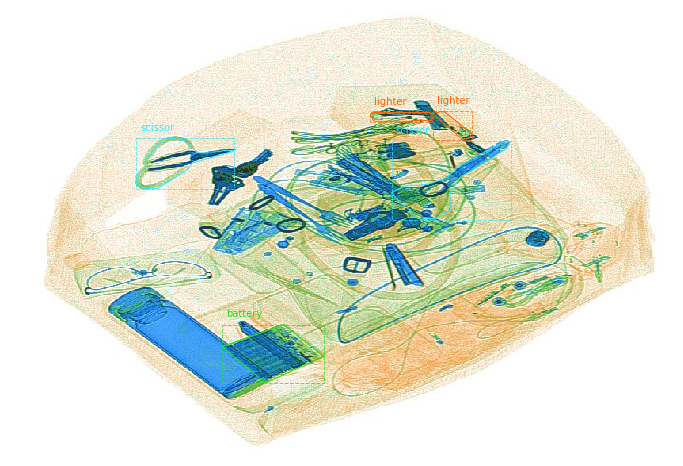

In [28]:
# test_set: 1,2,6,10,16,25,35,36,38,39,40,59,61,80,81,82,90,92,93,95
%matplotlib inline
imgId = 2
show_one_result(imgId=imgId, data_prefix=data_dir, coco=coco, colors=fixed_color_map, class_names=show_class_names)

<IPython.core.display.Javascript object>


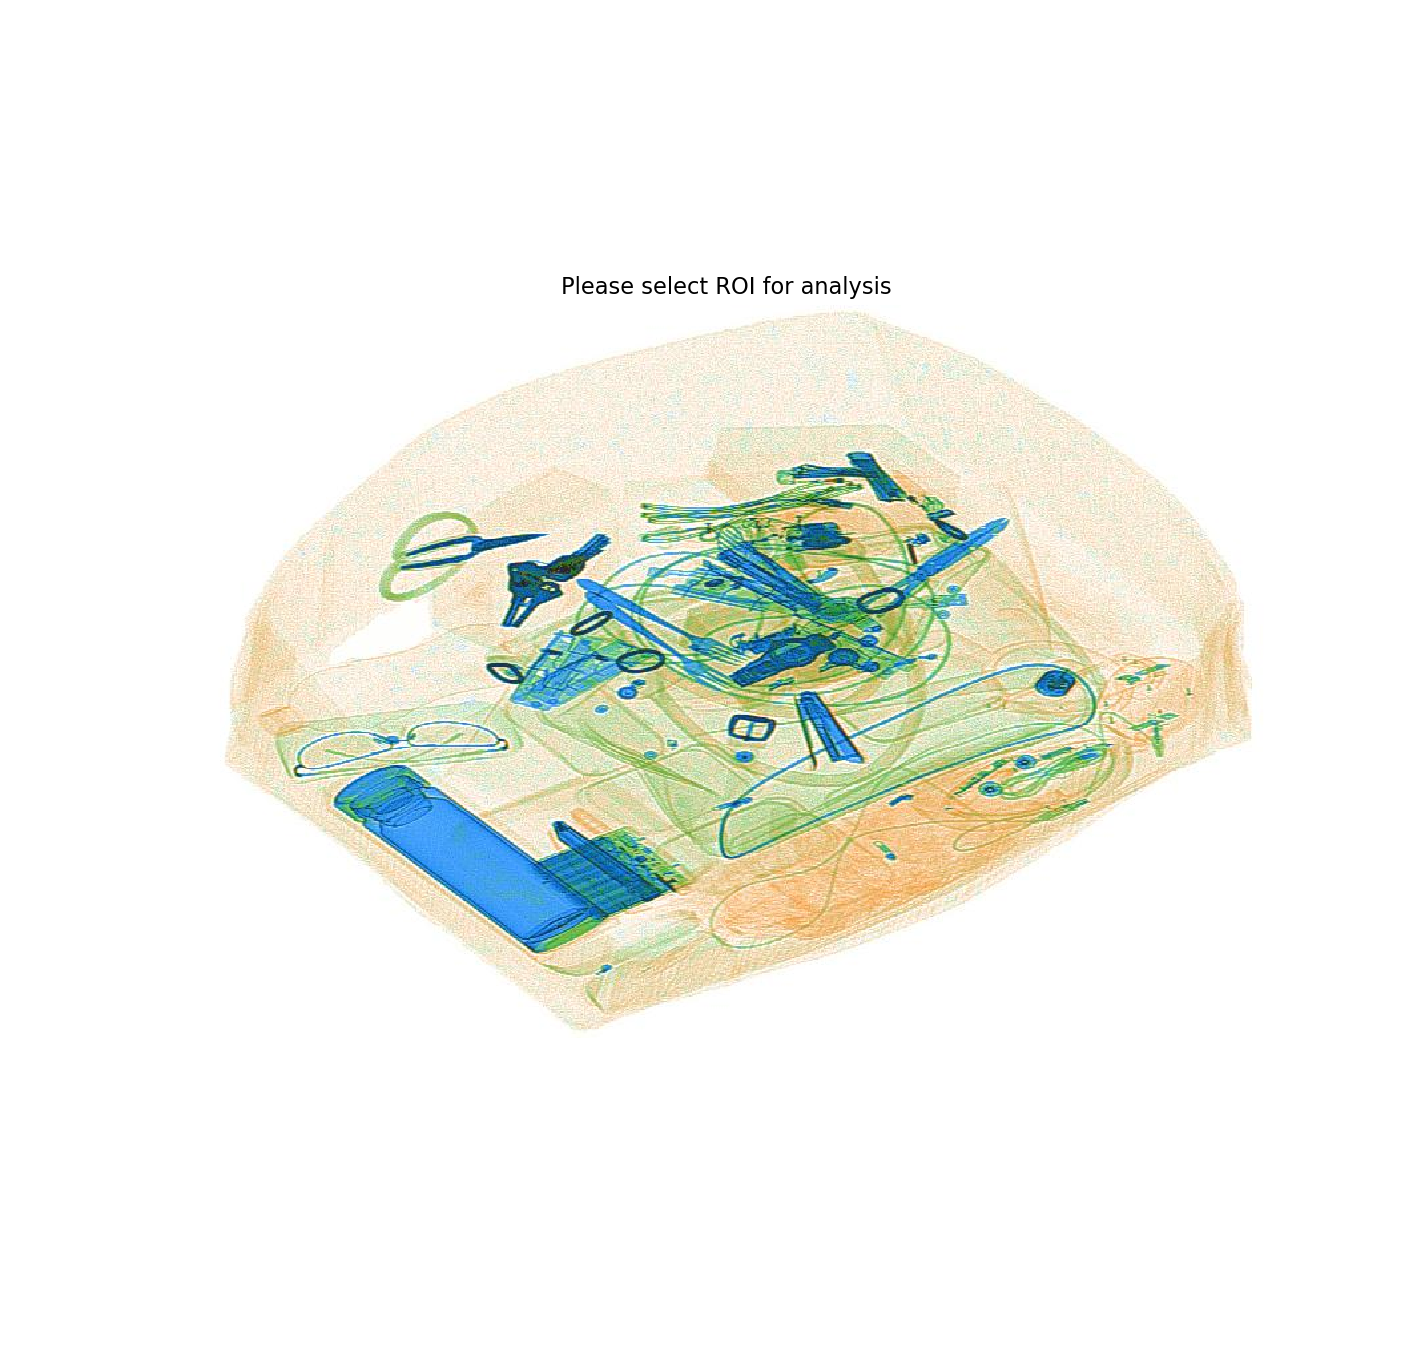

In [29]:
%matplotlib notebook
inference(imgId=imgId, data_prefix=data_dir, coco=coco, colors=fixed_color_map, class_names=show_class_names, show_bbox=True, figsize=(10.5, 10), sis=False)

In [73]:
def inference_image(img_path, figsize=(8.5, 8), show_bbox=False):
    cfg = exp.load_config_file('./config.yml', return_edict=True)
    device = torch.device('cuda:0')
    brs_mode = 'f-BRS-B'

    # get model
    torch.backends.cudnn.deterministic = True
    checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'resnet50_dh128_lvis')
    model = utils.load_is_model(checkpoint_path, device, cpu_dist_maps=True, norm_radius=260)
    predictor = get_predictor(model.to(device), device=device, brs_mode=brs_mode)
    clicker = clicker_.Clicker()
    input_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ])
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image_nd = input_transform(image).to(device)
    if image_nd is not None:
        predictor.set_input_image(image_nd)

    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(image, cmap='gray', interpolation='none')
    ax1.axis('off')
    ax1.set_title('Please select ROI for analysis')
    text=ax1.text(0,0, "", va="top", ha="left")
    if show_bbox:
        p = patches.Rectangle((0, 0), 0, 0, linewidth=1,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=(0.9, 0.0, 0.0), facecolor='none')
        ax1.add_patch(p)
    
    def on_button_press(event):
        x,y= int(event.xdata+0.5), int(event.ydata+0.5)
        if event.button == 1:
            positive = True
        elif event.button in [2, 3]:
            positive = False
        x,y = int(event.xdata+0.5), int(event.ydata+0.5)
        click = clicker_.Click(is_positive=positive, coords=(y, x))
        clicker.add_click(click)
        pred = predictor.get_prediction(clicker)
        pred_mask = pred > 0.5
        torch.cuda.empty_cache()
        tx = 'positive=%d, x_coord=%d, y_coord=%d' % (positive, x, y)
        text.set_text(tx)
        draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicker.clicks_list)
        mask_idx = np.where(pred_mask)
        y1 = np.min(mask_idx[0])
        y2 = np.max(mask_idx[0]) - y1
        x1 = np.min(mask_idx[1])
        x2 = np.max(mask_idx[1]) - x1
        box = (x1, y1, x2, y2)
        if show_bbox:
            p.set_bounds(x1, y1, x2, y2)        
        ax1.imshow(draw, cmap='gray', interpolation='none')
    
    def on_key_press(event):
        if event.key=='ctrl+z':
            clicker._remove_last_click()
            if len(clicker.clicks_list)!=0:
                pred = predictor.get_prediction(clicker)
                pred_mask = pred > 0.5
                torch.cuda.empty_cache()
                draw = vis.draw_with_blend_and_clicks(image, mask=pred_mask, clicks_list=clicker.clicks_list)
                mask_idx = np.where(pred_mask)
                y1 = np.min(mask_idx[0])
                y2 = np.max(mask_idx[0]) - y1
                x1 = np.min(mask_idx[1])
                x2 = np.max(mask_idx[1]) - x1
                box = (x1, y1, x2, y2)
                if show_bbox:
                    p.set_bounds(x1, y1, x2, y2)        
                ax1.imshow(draw, cmap='gray', interpolation='none')
            else:
                clicker.reset_clicks()
        elif event.key=='escape':
            clicker.reset_clicks()
        
    fig.canvas.mpl_connect("button_press_event",  on_button_press)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    plt.show()


<IPython.core.display.Javascript object>


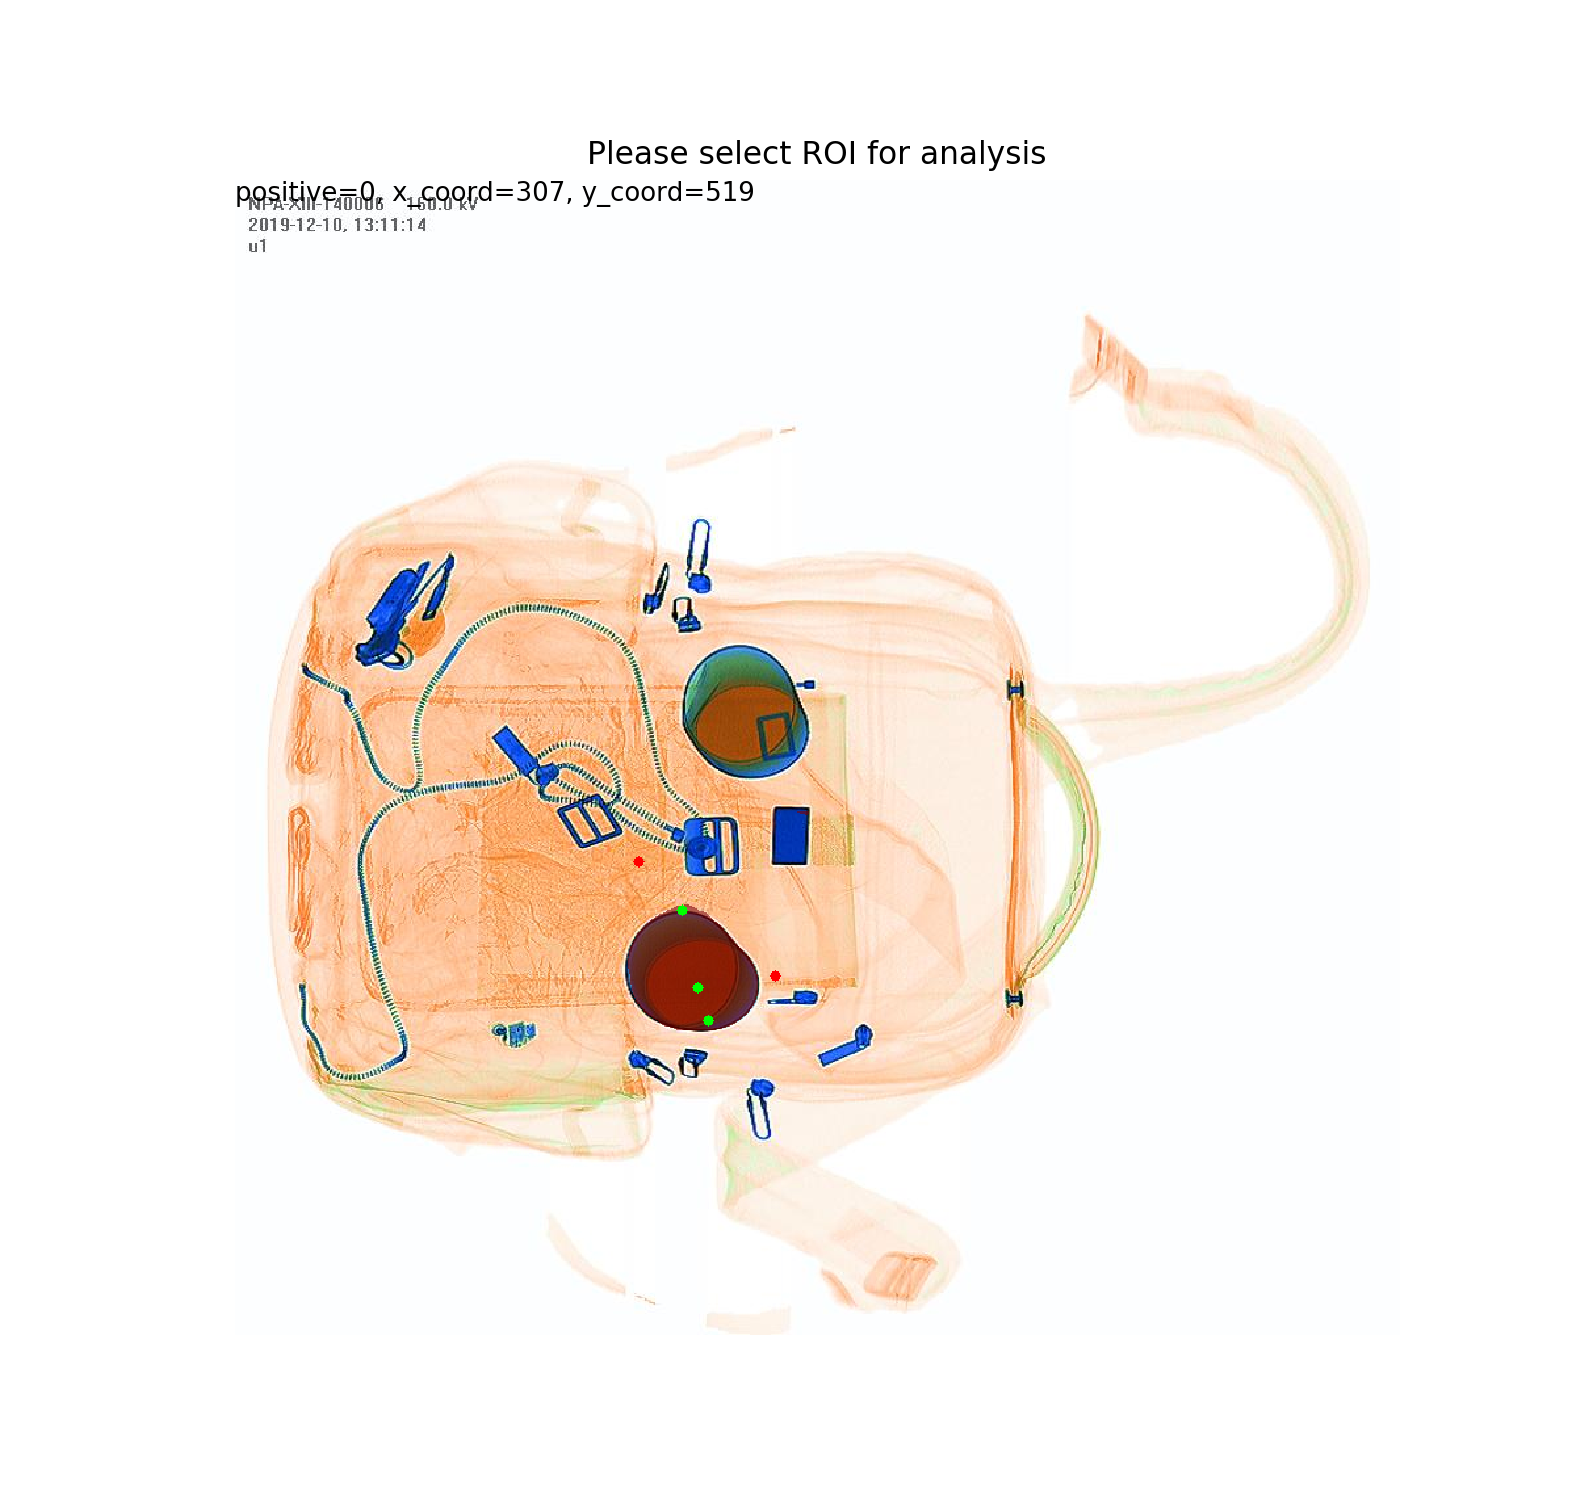

In [70]:
%matplotlib notebook
img_path = '/data/x-ray/cocovis/jiuzhou/images/can_07.jpg'
inference_image(img_path, figsize=(8.5, 8), show_bbox=False)

<IPython.core.display.Javascript object>


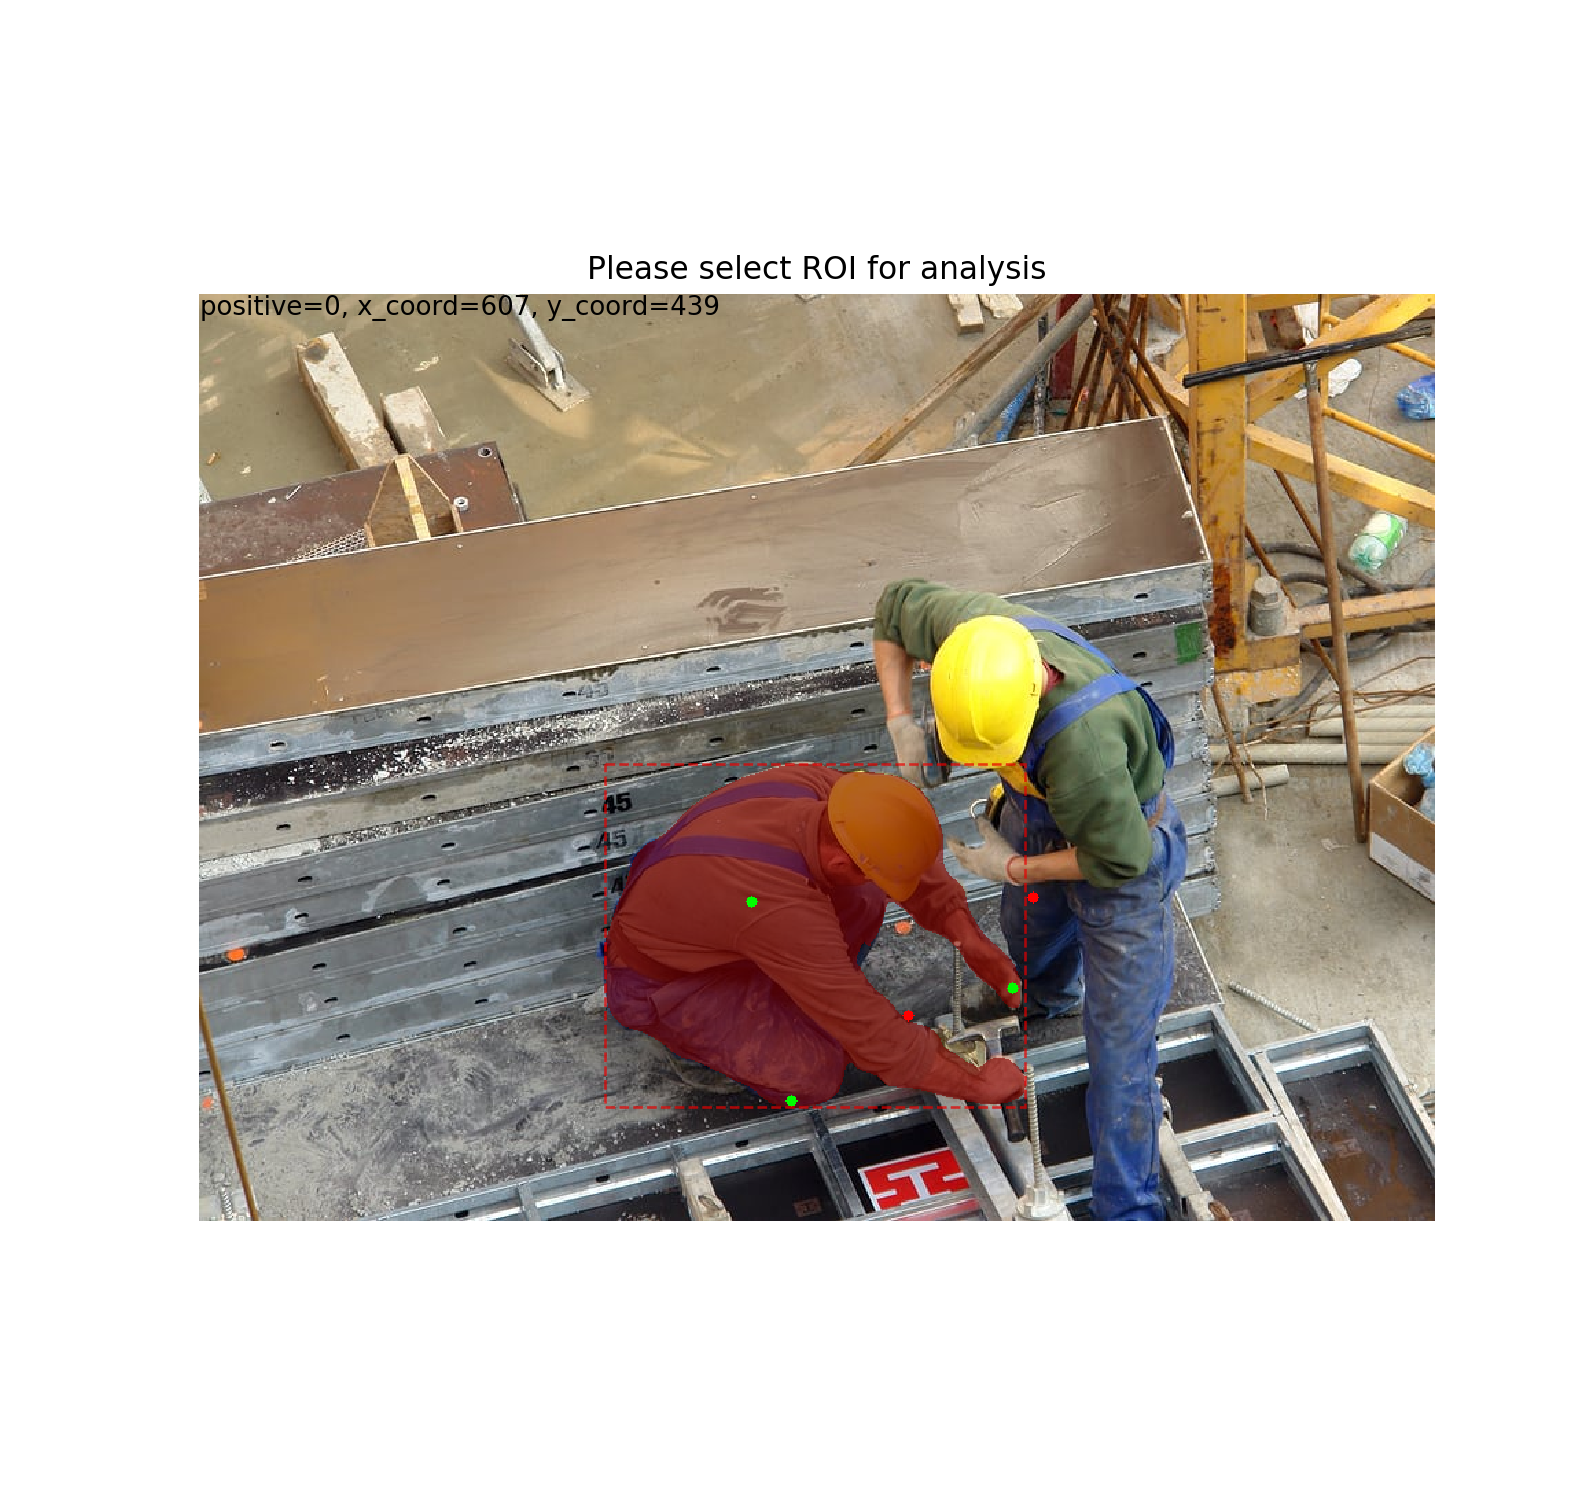

In [78]:
%matplotlib notebook
# img_path = '/home/hui.yuan/data/xray/train/domain4/400076.jpg'
img_path = '/data/hardhat_uniform/JPEGImages/helmet_part2_001081.jpg'
inference_image(img_path, figsize=(8.5, 8), show_bbox=True)